In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import texttable
import sys
sys.path.append("../src")
from data_proc import *
from baselines import *
from policy import *
from simulate import *
from visualize import *

pd.options.mode.chained_assignment = None

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
DATA_PATH = "../data/warfarin.csv"  # path to raw Warfarin data file

In [4]:
def simulate_policies(simulator, policies, num_runs=5):
    """
    Simulates a list of policies, each for 'num_runs' times
    Plots the regret/T & validation accuracy curves of all policies for comparison
    
    All policies are simulated using the same sets of random permutations
    
    simulator:
        WarfarinSimulator instance
    policies:
        List of (Policy, string) tuples, where the string is a description of the policy
        The Policy instances should implement reset(), choose_arm(), and update_policy()
    """
    base_seed = np.random.randint(1000)  # randomizing dataset permutations
    plot_regret_bound, plot_acc_bound, drop_k = False, False, 0  # visualization options
    
    # record regret statistics of all policies
    table = texttable.Texttable()
    table.header(['Policy', 'Mean', 'Std', 'Min', 'Max'])
    
    for policy, policy_name in policies:
        if policy_name is None:
            policy_name = policy.__class__.__name__
        reward_histories = []
        val_accuracy_histories = []
        regrets = []
        
        print("Start simulating {} for {} times".format(policy_name, num_runs))
        for i in range(num_runs):
            # Reset the policy to its initial states
            policy.reset()
            
            # random_seed makes sure all policies are simulated using the same random permutations
            simulator.simulate(policy, eval_every=50, random_seed=(base_seed+i))
            
            # Record results of this simulation run
            regrets.append(simulator.get_total_regret())
            reward_histories.append(simulator.get_reward_history())
            val_accuracy_histories.append(simulator.get_validation_history()[1])
            print("Total regret: {}".format(regrets[-1]))

        table.add_row((policy_name, int(np.mean(regrets)), int(np.std(regrets)),
                      int(np.min(regrets)), int(np.max(regrets))))
        
        # Plot regret/T & validation accuracy curves for this policy
        val_step_history = simulator.get_validation_history()[0]
        plt.figure("regret")
        plot_incorrect_fraction(reward_histories, policy_name, plot_regret_bound, drop_k)
        plt.figure("val-acc")
        plot_validation_accuracy(val_step_history, val_accuracy_histories, policy_name, plot_acc_bound, drop_k)
        
    # Label the plots
    plt.figure("regret")
    plt.legend(loc='upper right')
    plt.title("Average Fraction of Incorrect Decisions")
    plt.xlabel("t")
    plt.grid()
    plt.figure("val-acc")
    plt.legend(loc='lower right')
    plt.title("Cross Validation Accuracy")
    plt.xlabel("t")
    plt.grid()
    
    # Print regret statistics of all policies
    print(table.draw())

In [5]:
# Instantiate a Warfarin simulator
simulator = WarfarinSimulator(DATA_PATH, test_size=500, add_bias=True)

Instantiated a Warfarin Bandit simulator!
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500


Start simulating Fixed-dose for 10 times
5028/5028 [==============================] - 0s     
Total regret: 2308
5028/5028 [==============================] - 0s     
Total regret: 2298
5028/5028 [==============================] - 0s     
Total regret: 2298
5028/5028 [==============================] - 0s     
Total regret: 2303
5028/5028 [==============================] - 0s     
Total regret: 2300
5028/5028 [==============================] - 0s     
Total regret: 2302
5028/5028 [==============================] - 0s     
Total regret: 2293
5028/5028 [==============================] - 0s     
Total regret: 2317
5028/5028 [==============================] - 0s     
Total regret: 2299
5028/5028 [==============================] - 0s     
Total regret: 2306
Start simulating UCB1 for 10 times
5028/5028 [==============================] - 0s     
Total regret: 2392
5028/5028 [==============================] - 0s     
Total regret: 2382
5028/5028 [==============================] - 0s     
Total r

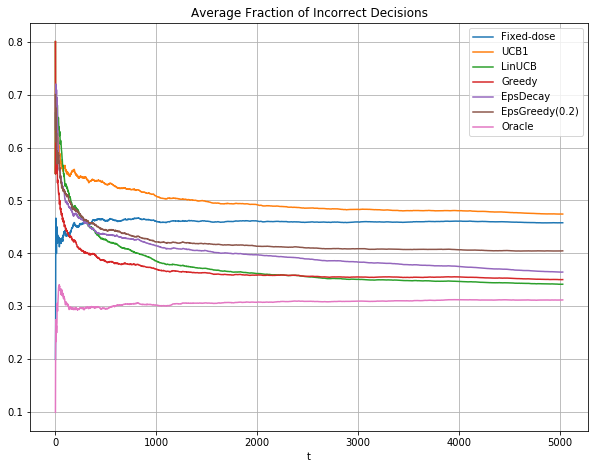

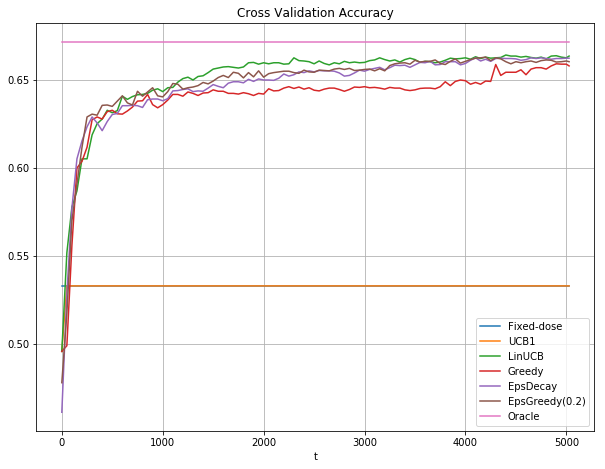

In [7]:
# Simulate the policies and compare performance
simulate_policies(simulator, [
    (WarfarinFixedDosePolicy(), "Fixed-dose"),
    (UCB1Policy(num_arms=3), "UCB1"),
    (LinUCBPolicy(simulator.p, num_arms=3, alpha=1.0), "LinUCB"),
    (EpsilonGreedyPolicy(simulator.p, num_arms=3, eps_schedule=lambda x: 0), "Greedy"),
    (EpsilonGreedyPolicy(simulator.p, num_arms=3, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
    (EpsilonGreedyPolicy(simulator.p, num_arms=3, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
    (WarfarinOraclePolicy(DATA_PATH), "Oracle"),
], num_runs=10)

In [8]:
# Idea: Look at how often LinUCB chooses "suboptimal" actions in order to explore
# Conclusion: It is quite actively exploring!!
linucb = LinUCBPolicy(simulator.p, num_arms=3, alpha=1.0)
count = []
for i in range(10):
    linucb.reset()
    simulator.simulate(linucb, eval_every=10000)
    count.append(linucb.get_num_suboptimal_actions())
print(np.mean(count))
print(count)

5028/5028 [==============================] - 0s     
416.2
[396, 453, 415, 441, 428, 397, 455, 346, 432, 399]
